Mean Selected: [[-1, 2], [2, -1]]
Selected Covariance Matrix : [array([[ 2.39646405, -0.29211247],
       [-0.29211247,  0.41166215]]), array([[2.39676631, 0.33424517],
       [0.33424517, 0.4052158 ]])]
Dataset shape: (10000, 2)
(8000, 2)
5.525692393284666
Weights of model: [0.5 0.5]
(2, 2, 2)


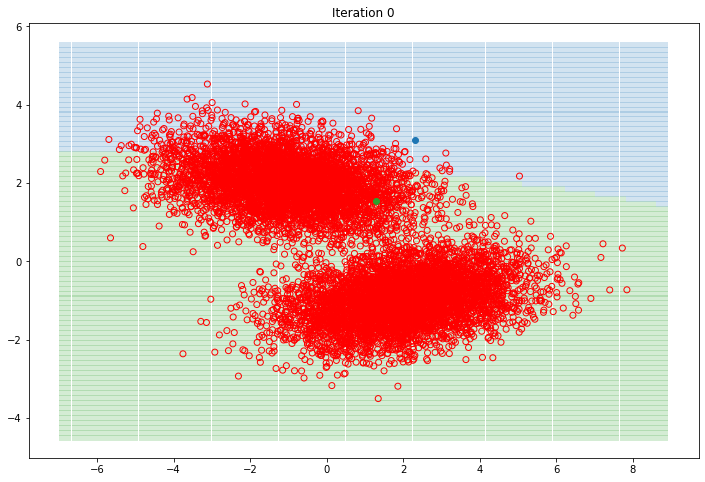

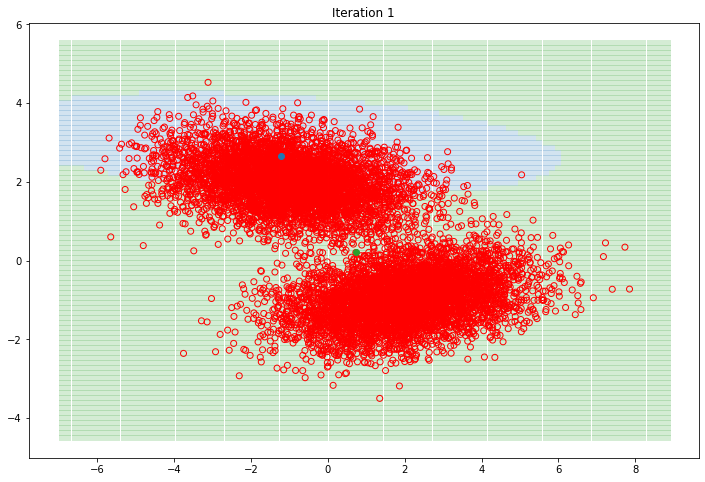

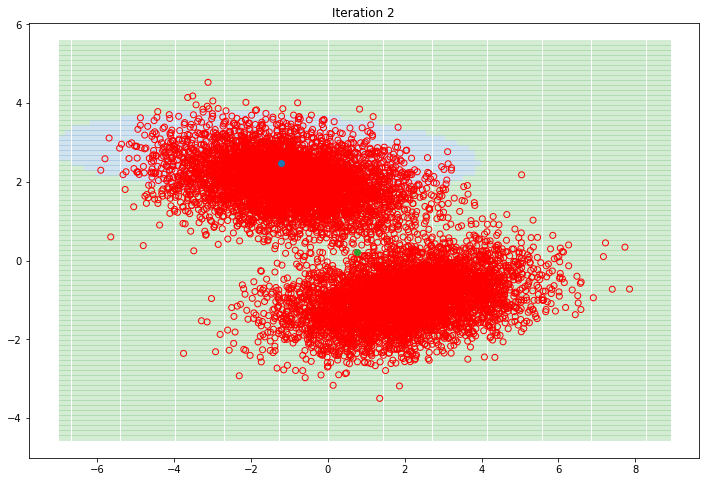

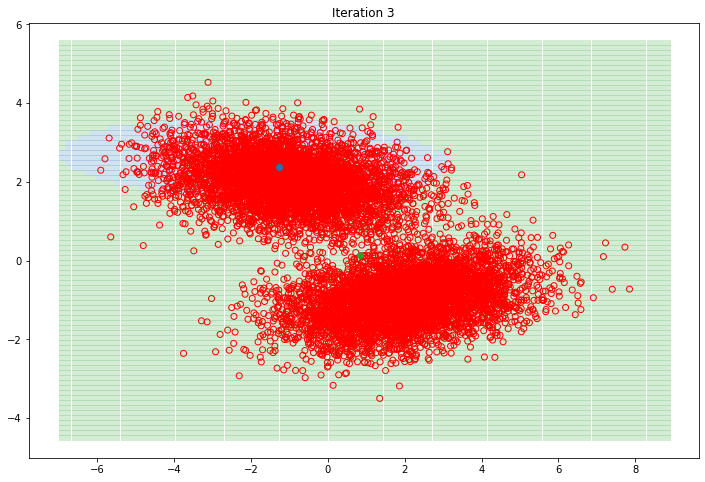

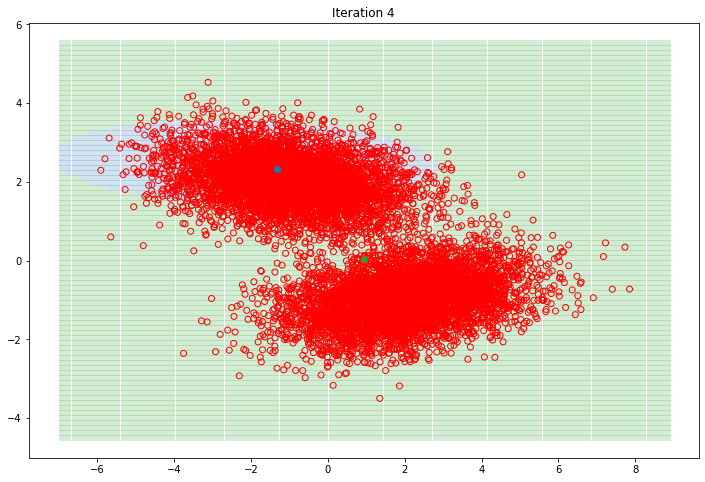

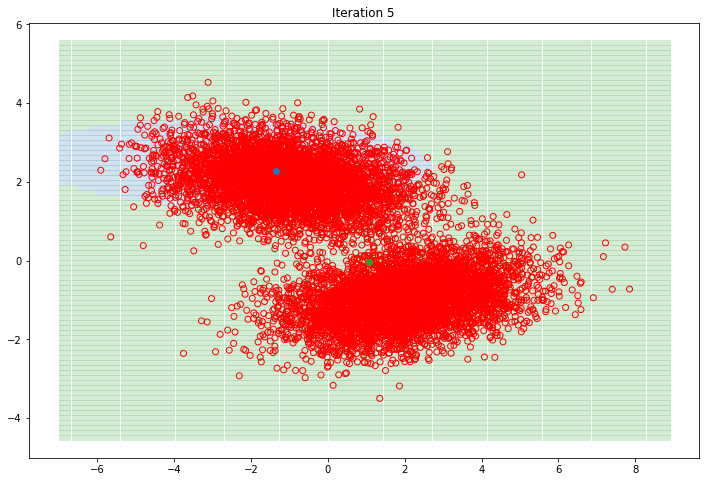

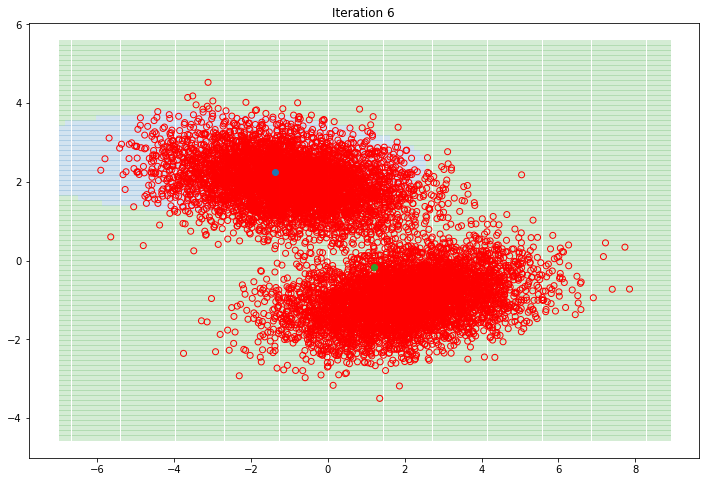

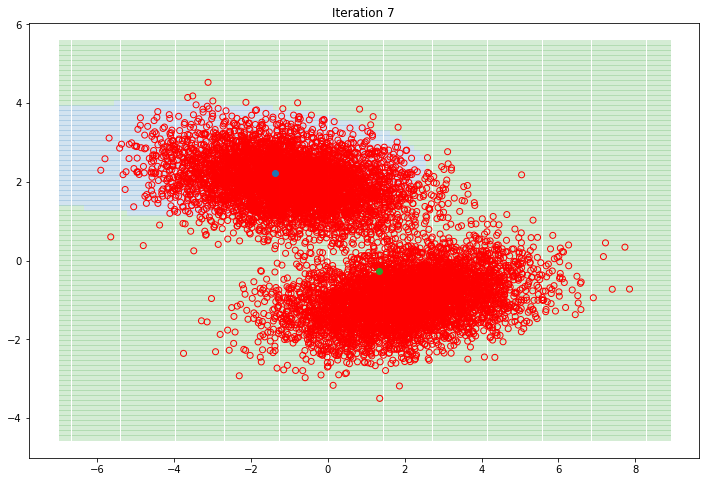

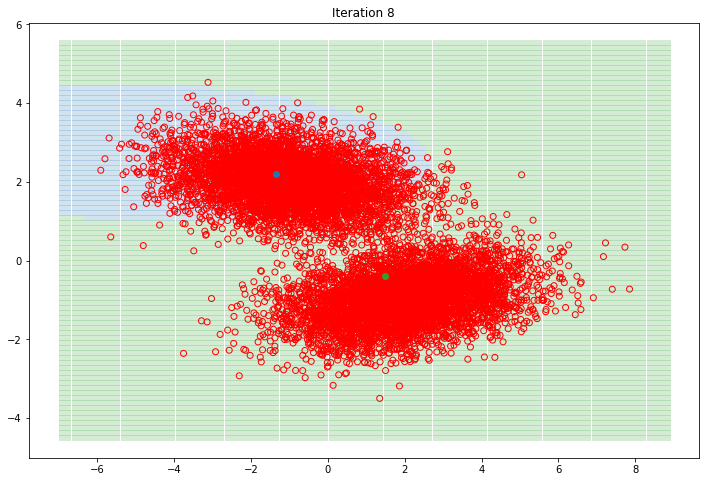

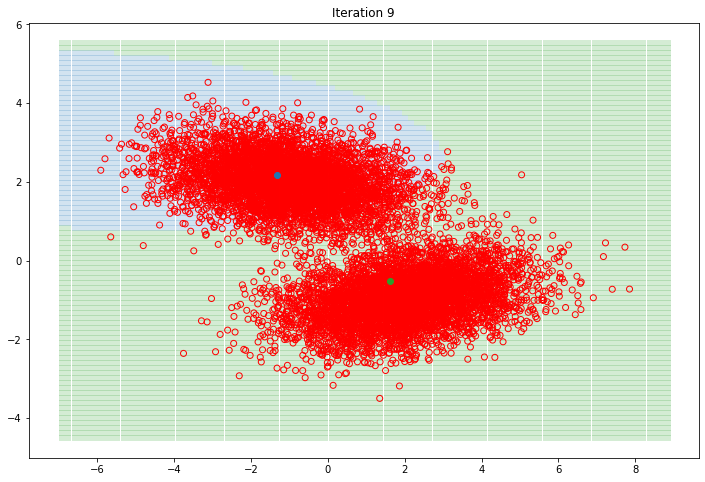

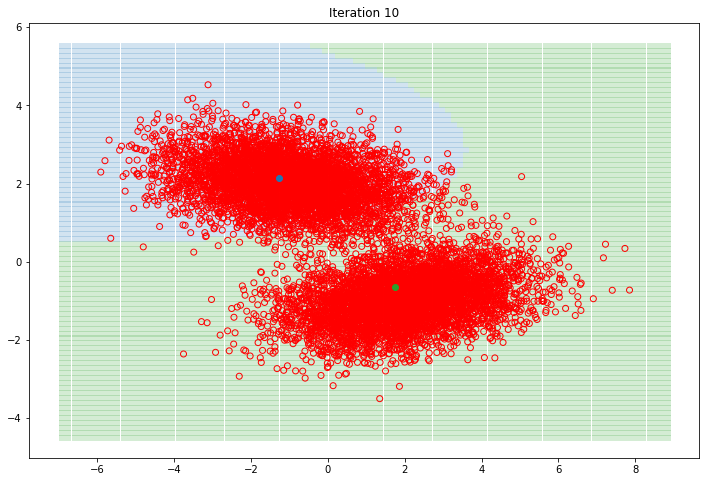

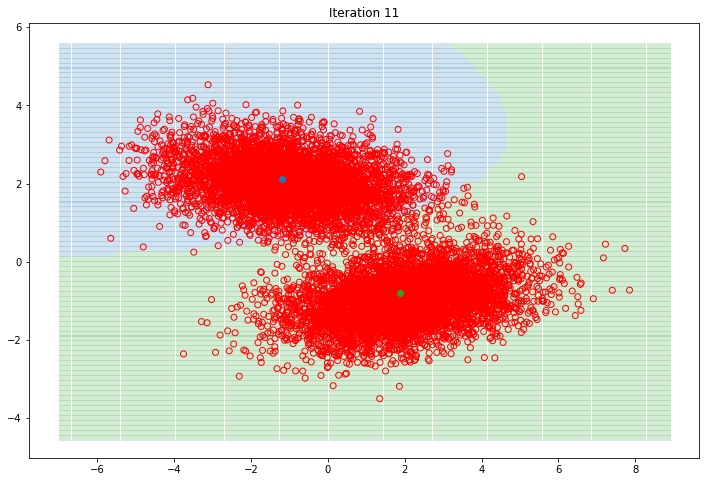

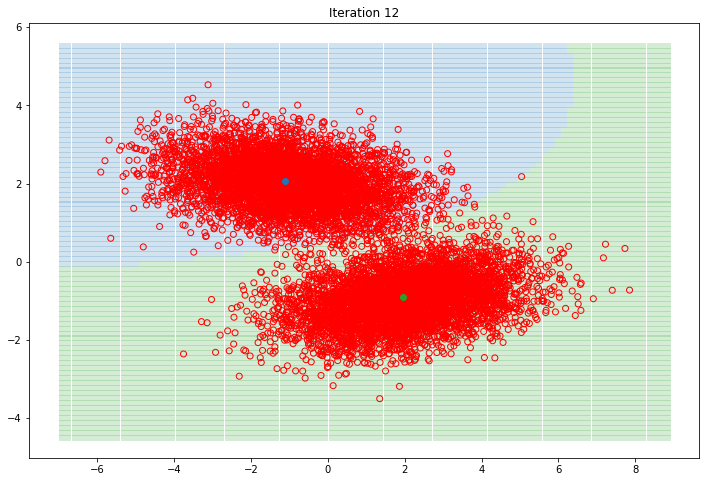

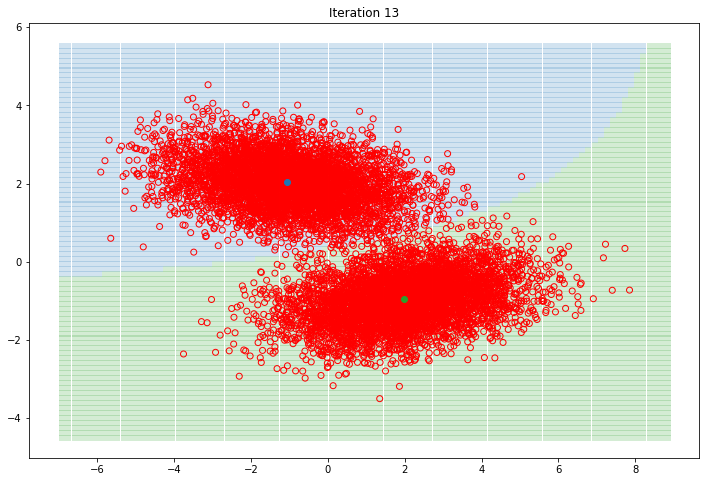

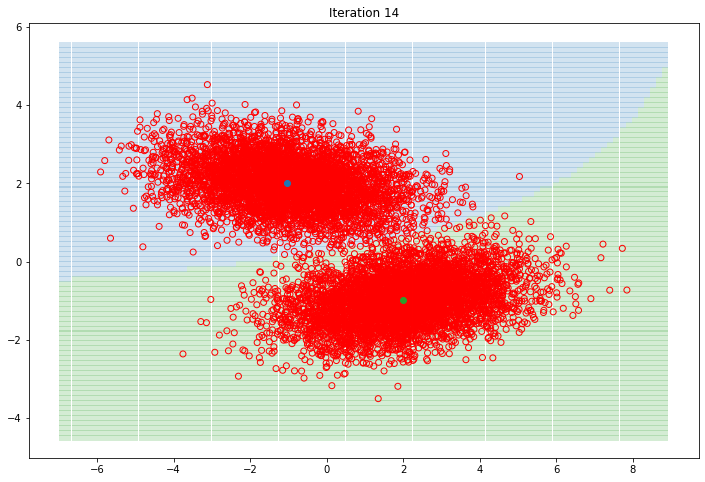

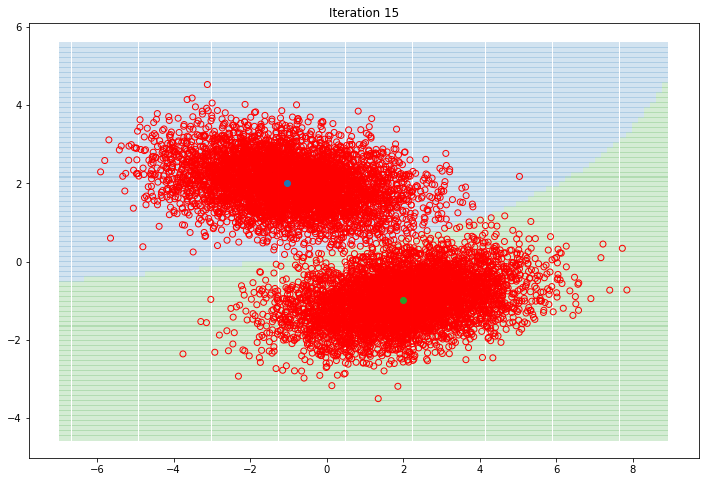

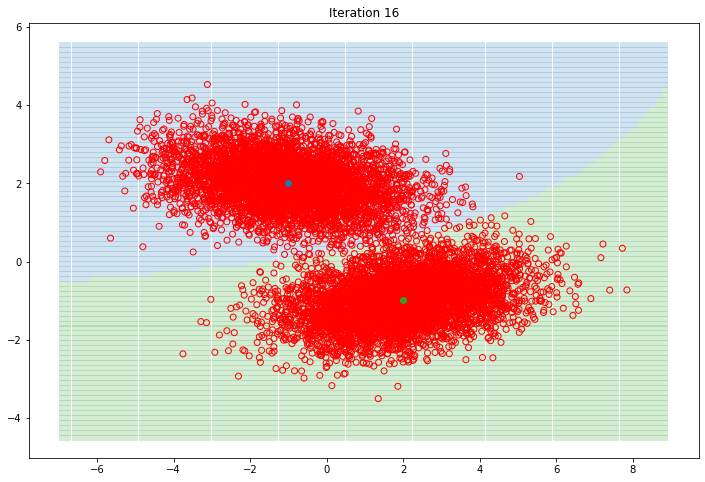

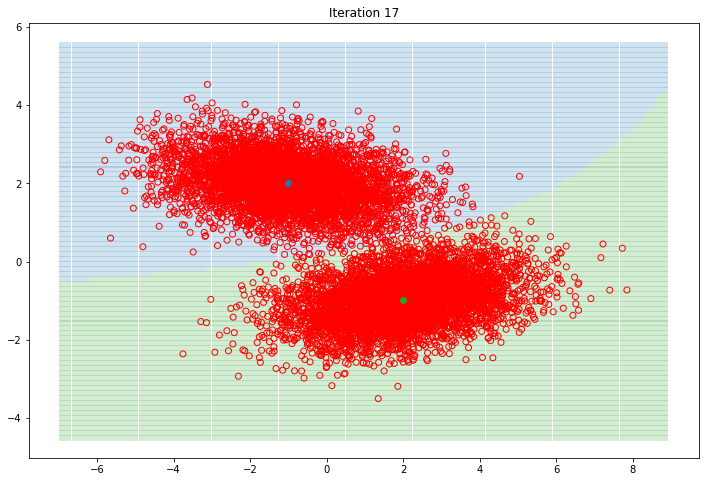

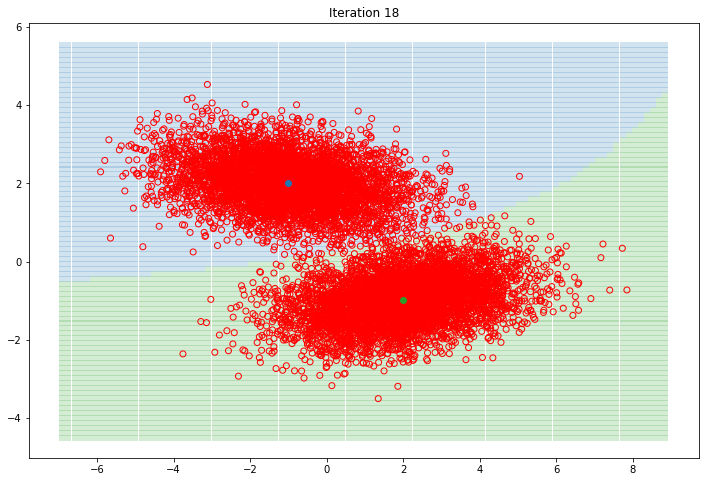

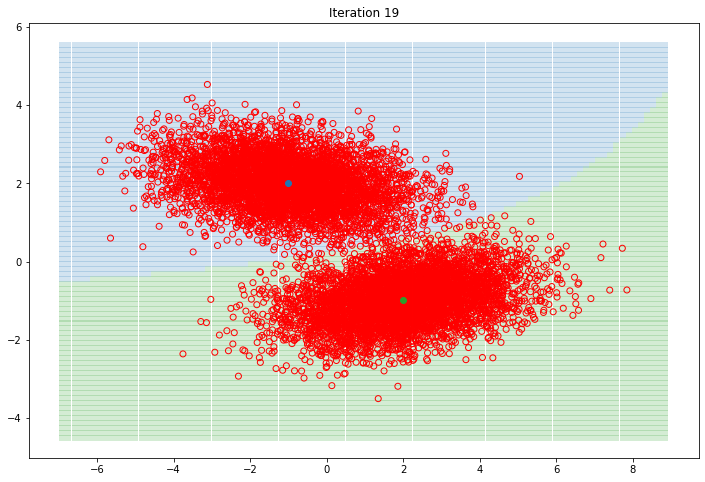

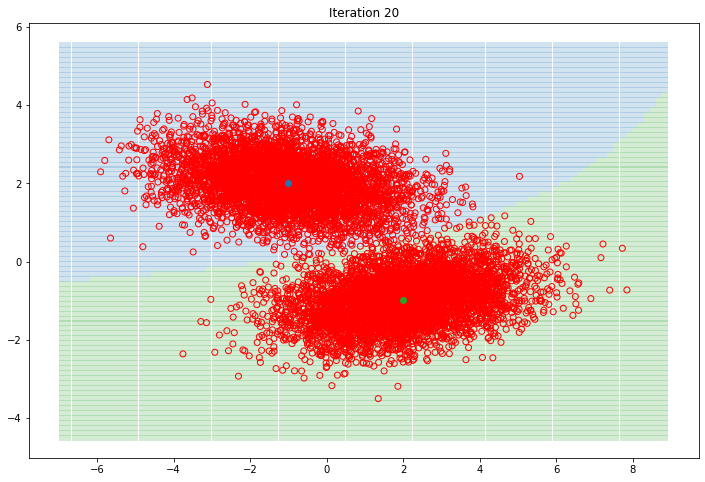

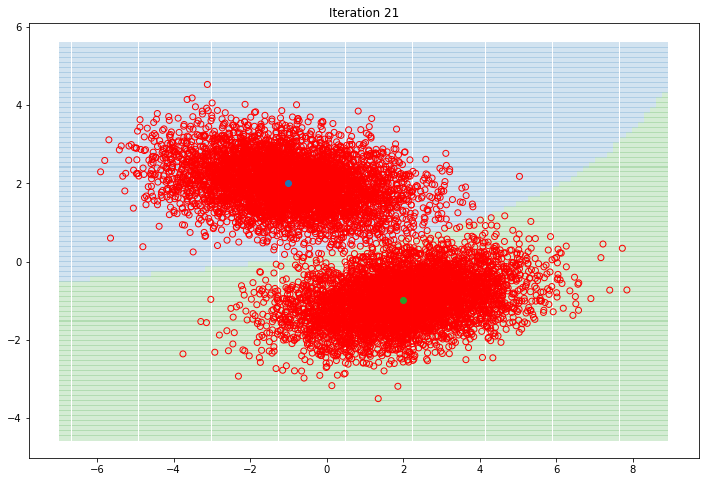

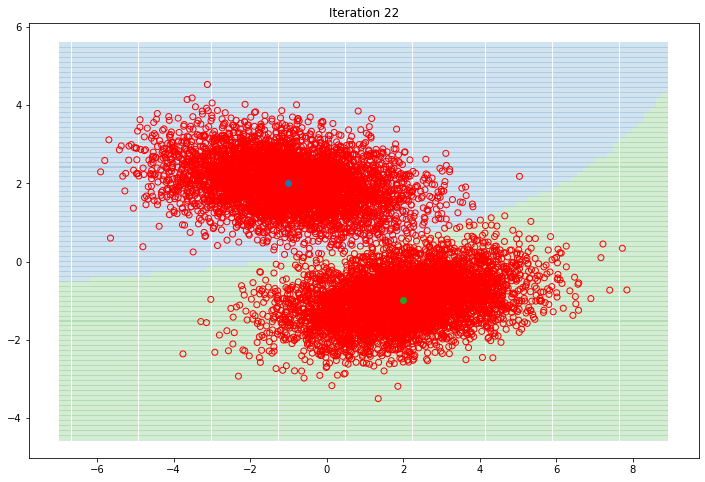

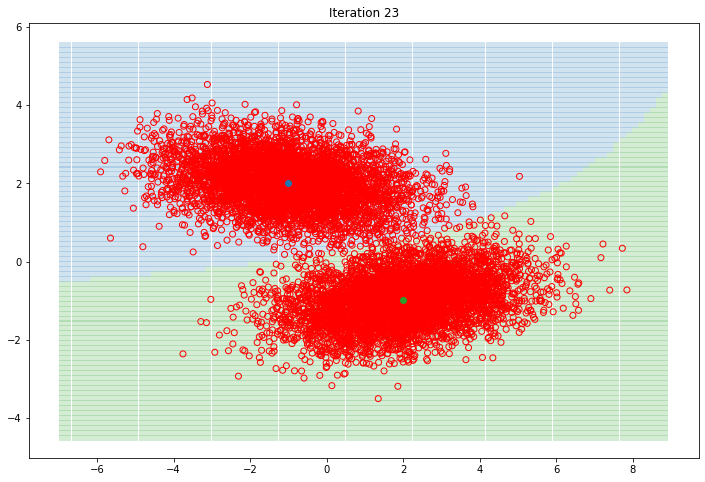

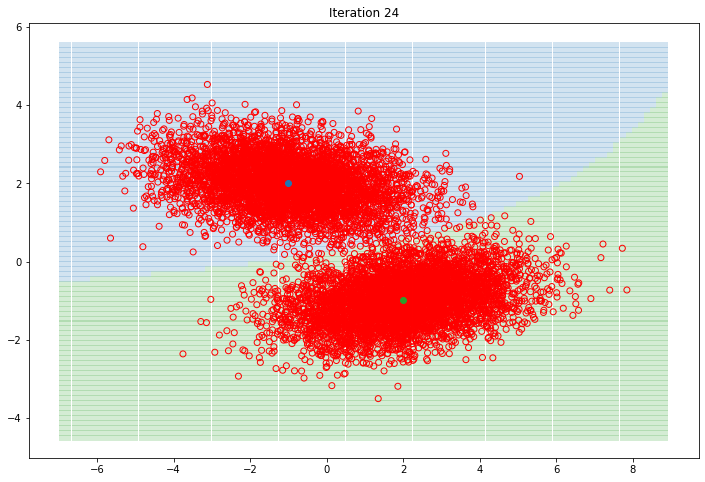

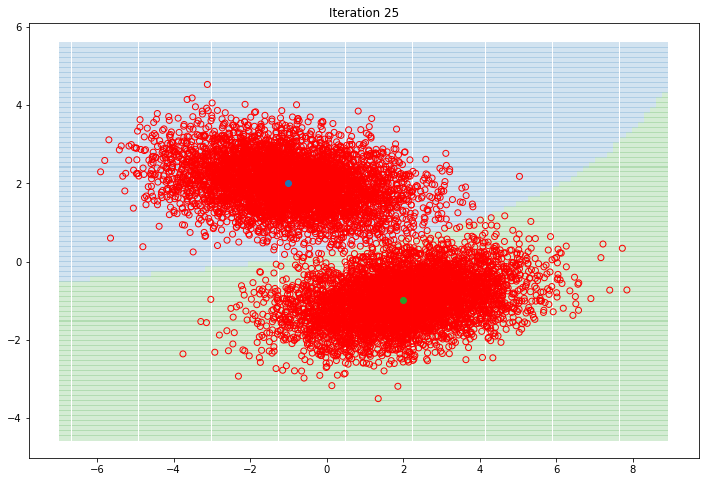

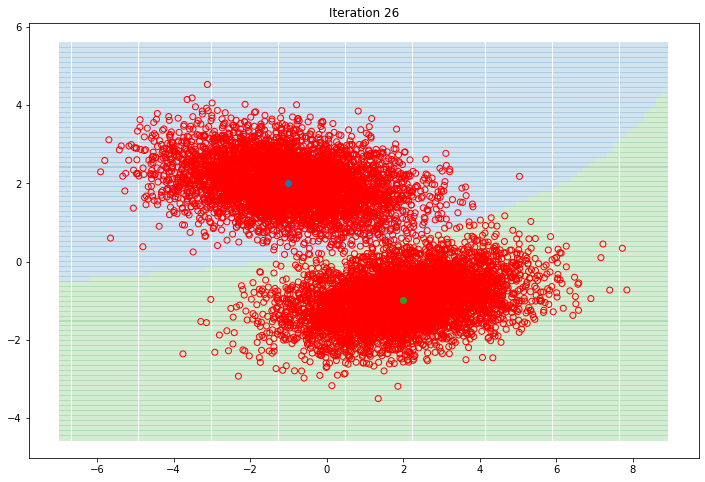

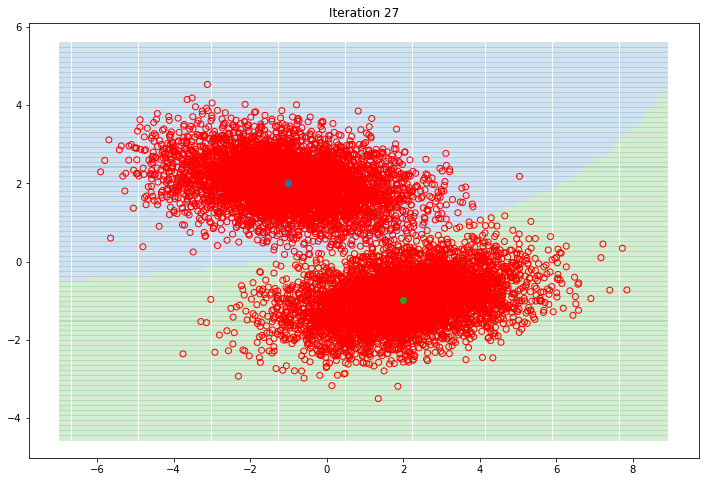

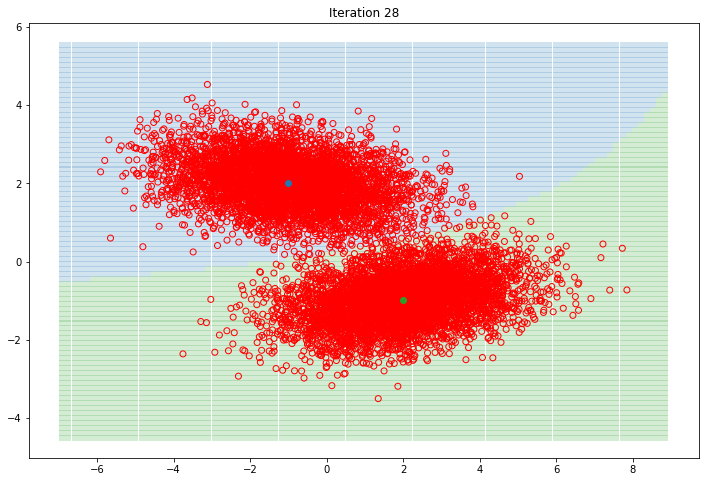

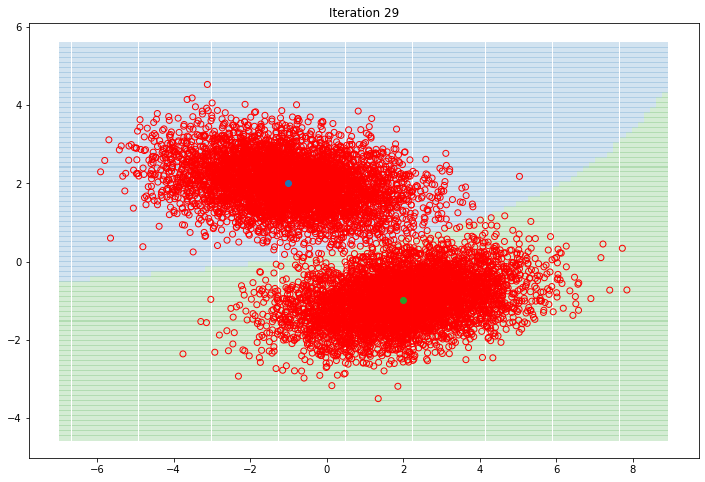

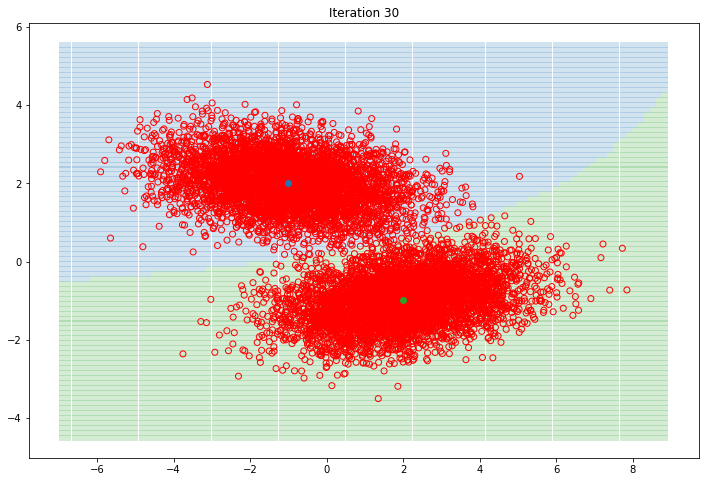

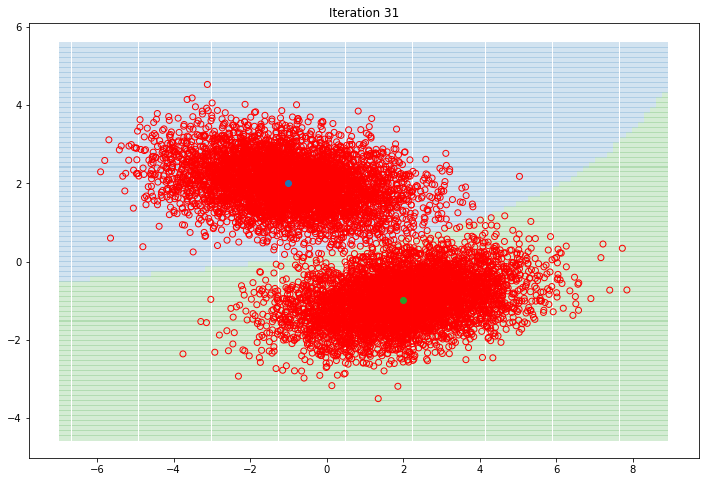

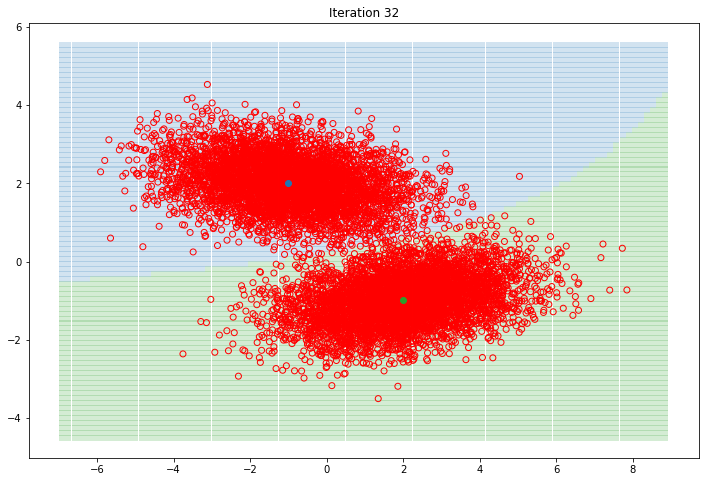

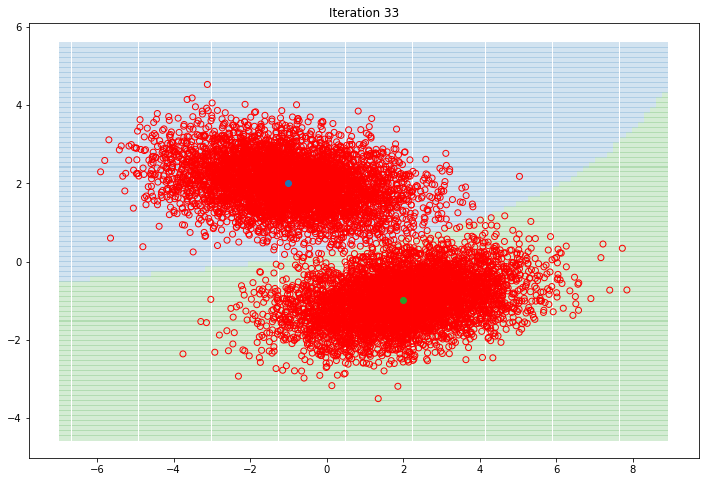

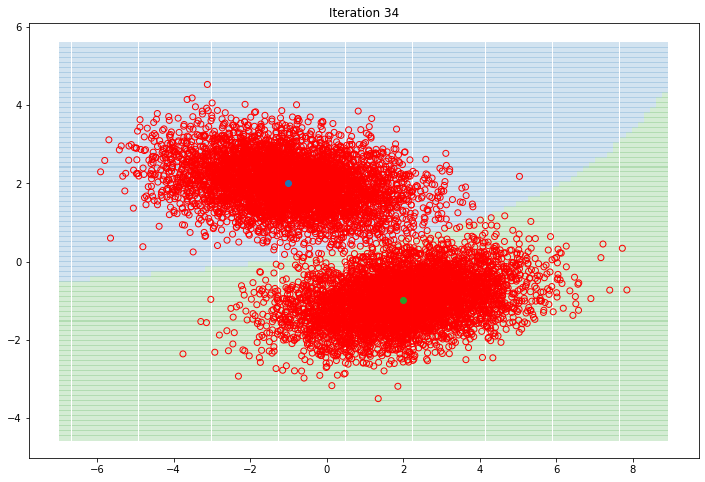

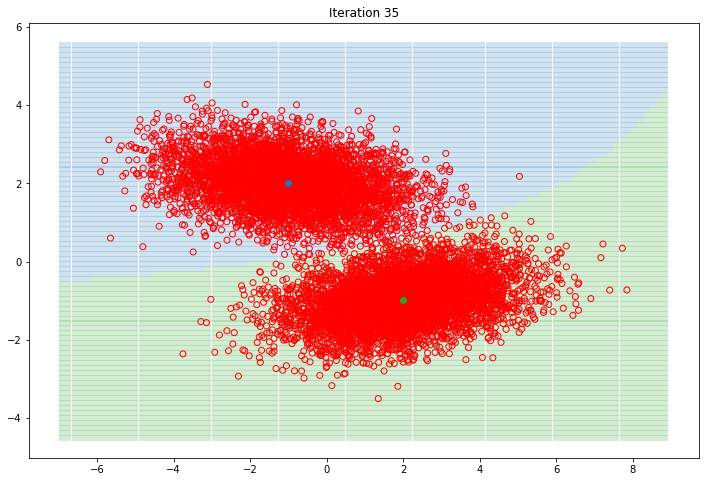

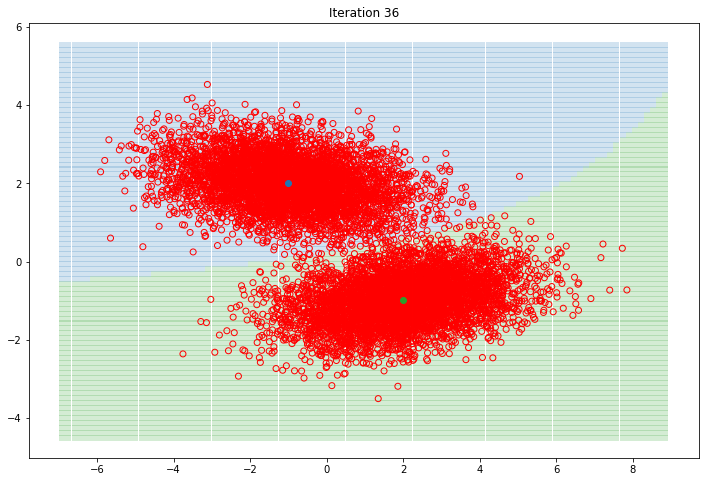

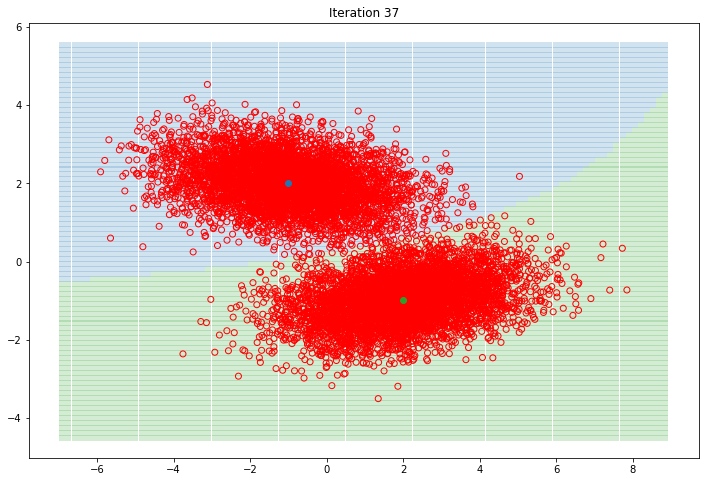

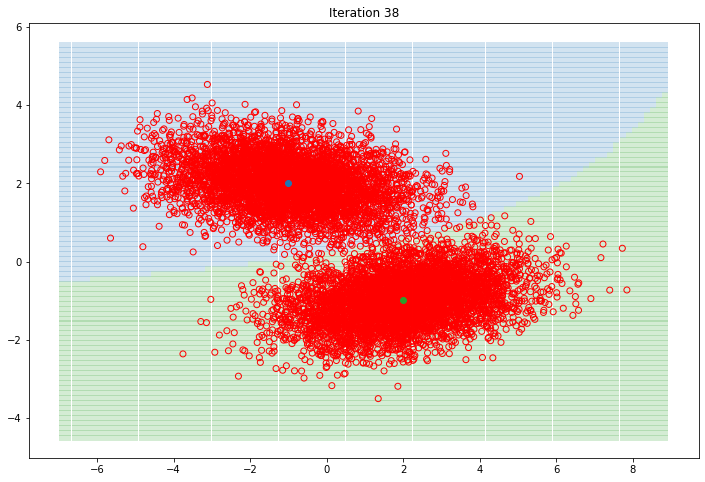

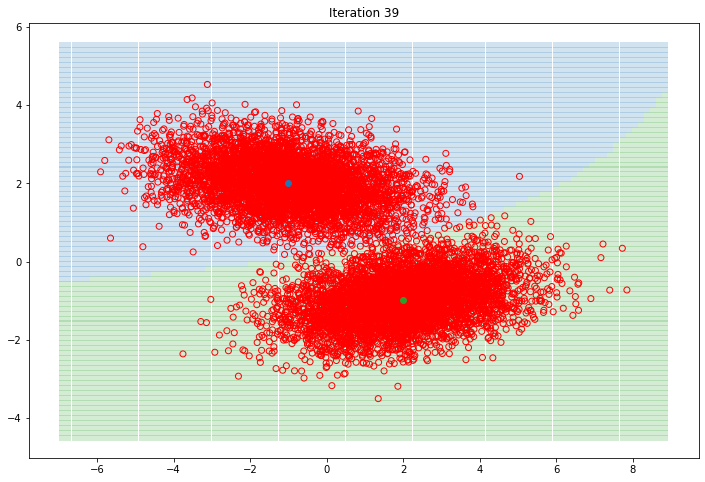

In [9]:
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix
plt.rcParams["axes.grid"] = False

# define the number of samples to be drawn
num_of_datapoints = 5000

# define the mean points for each of the systhetic cluster centers
mean_array = [[-1,2 ], [2,-1]]
print("Mean Selected:",mean_array)
# for each cluster center, create a Positive semidefinite convariance matrix
Cov_array = []

for s in range(len(mean_array)):
    Cov_array.append(make_spd_matrix(2))

print("Selected Covariance Matrix :",Cov_array)
dataset = []
for mean, cov in zip(mean_array,Cov_array):
  x = np.random.multivariate_normal(mean, cov, num_of_datapoints)
  dataset += list(x)
  
dataset = np.array(dataset)
np.random.shuffle(dataset)
print("Dataset shape:", dataset.shape)

# Create a grid for visualization purposes 
values = np.linspace(np.min(dataset[...,0])-1,np.max(dataset[...,0])+1,100)
labels = np.linspace(np.min(dataset[...,1])-1,np.max(dataset[...,1])+1,80)
dataset_,Y_ = np.meshgrid(values,labels)
pos = np.array([dataset_.flatten(),Y_.flatten()]).T
print(pos.shape)
print(np.max(pos[...,1]))

# define the number of classes to be learned
classes = 2

# create and initialize the cluster centers and the weight paramters
weights = np.ones((classes)) / classes
means = np.random.choice(dataset.flatten(), (classes,dataset.shape[1]))
#print(means)
print("Weights of model:", weights)

# create and initialize a Positive semidefinite convariance matrix 
cov = []
for i in range(classes):
  cov.append(make_spd_matrix(dataset.shape[1]))
cov = np.array(cov)
print(cov.shape)

colors = ['tab:green', 'tab:blue', 'tab:orange', 'magenta', 'yellow', 'red', 'brown', 'grey']
eps=1e-8

# run GMM for 40 steps
for step in range(40):

  # visualize the learned clusters
  if step % 1 == 0:
    plt.figure(figsize=(12,int(8)))
    plt.title("Iteration {}".format(step))
    axes = plt.gca()
    
    likelihood = []
    for j in range(classes):
      likelihood.append(multivariate_normal.pdf(x=pos, mean=means[j], cov=cov[j]))
    likelihood = np.array(likelihood)
    predictions = np.argmax(likelihood, axis=0)
    
    for c in range(classes):
      pred_ids = np.where(predictions == c)
      plt.scatter(pos[pred_ids[0],0], pos[pred_ids[0],1], color=colors[c], alpha=0.2, edgecolors='none', marker='s')
    
    plt.scatter(dataset[...,0], dataset[...,1], facecolors='none', edgecolors='red')
    
    for j in range(classes):
      plt.scatter(means[j][0], means[j][1], color=colors[j])

    #plt.savefig("img_{0:02d}".format(step), bbox_inches='tight')
    plt.show()

  likelihood = []
  # Expectation step
  for j in range(classes):
    likelihood.append(multivariate_normal.pdf(x=dataset, mean=means[j], cov=cov[j]))
  likelihood = np.array(likelihood)
  assert likelihood.shape == (classes, len(dataset))
    
  b = []
  # Maximization step 
  for j in range(classes):
    # use the current values for the parameters to evaluate the posterior
    # probabilities of the data to have been generanted by each gaussian
    b.append((likelihood[j] * weights[j]) / (np.sum([likelihood[i] * weights[i] for i in range(classes)], axis=0)+eps))

    # updage mean and variance
    means[j] = np.sum(b[j].reshape(len(dataset),1) * dataset, axis=0) / (np.sum(b[j]+eps))
    cov[j] = np.dot((b[j].reshape(len(dataset),1) * (dataset - means[j])).T, (dataset - means[j])) / (np.sum(b[j])+eps)

    # update the weights
    weights[j] = np.mean(b[j])
    
    assert cov.shape == (classes, dataset.shape[1], dataset.shape[1])
    assert means.shape == (classes, dataset.shape[1])